In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
from itertools import product
import warnings
warnings.filterwarnings(action='ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dacon-final/dacon_data/new_submission_info.csv
/kaggle/input/dacon-final/dacon_data/new_user_info.csv
/kaggle/input/dacon-final/dacon_data/new_competition_info.csv
/kaggle/input/dacon-final/dacon_data/new_login_info.csv
/kaggle/input/dacon-final/dacon_data/train.csv
/kaggle/input/2020daconcupsecondversion/open_data (1)/info_user.csv
/kaggle/input/2020daconcupsecondversion/open_data (1)/info_submission.csv
/kaggle/input/2020daconcupsecondversion/open_data (1)/info_login.csv
/kaggle/input/2020daconcupsecondversion/open_data (1)/info_competition.csv
/kaggle/input/2020daconcupsecondversion/open_data (1)/submission.csv
/kaggle/input/2020daconcupsecondversion/open_data (1)/train.csv
/kaggle/input/return/dacon_cup (17).csv


In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
def is_vacation(date): #방학 기간 중인지 확인
    if ((date >= pd.Timestamp(2019, 6, 20)) & (date <= pd.Timestamp(2019, 8, 31))):
        return True
    elif ((date >= pd.Timestamp(2020, 6, 20)) & (date <= pd.Timestamp(2020, 8, 31))):
        return True
    elif ((date >= pd.Timestamp(2021, 6, 20)) & (date <= pd.Timestamp(2021, 8, 31))):
        return True
    elif ((date >= pd.Timestamp(2020, 12, 15)) & (date <= pd.Timestamp(2020, 2, 28))):
        return True
    elif ((date >= pd.Timestamp(2019, 12, 15)) & (date <= pd.Timestamp(2019, 2, 28))):
        return True
    elif ((date >= pd.Timestamp(2018, 12, 15)) & (date <= pd.Timestamp(2018, 2, 28))):
        return True
    else:
        return False


def dacon_rmse(true, pred, **kwargs): #규칙에 나와있는 weighted rmse 일부 구현
    score = np.sqrt(np.mean(np.square(true - pred)))
    return score

from sklearn.metrics import make_scorer
my_scorer = make_scorer(dacon_rmse, greater_is_better=True)

# 데이터 불러오기

In [4]:
train_final = pd.read_csv("/kaggle/input/dacon-final/dacon_data/train.csv", encoding='cp949')
train =pd.read_csv("/kaggle/input/2020daconcupsecondversion/open_data (1)/train.csv", encoding='cp949')
train = pd.concat([train, train_final]) #1차와 2차를 하나로 합쳐서 계산.

info_user = pd.read_csv("/kaggle/input/dacon-final/dacon_data/new_user_info.csv", encoding='cp949')
info_login = pd.read_csv("/kaggle/input/dacon-final/dacon_data/new_login_info.csv", encoding='cp949')
info_comp = pd.read_csv("/kaggle/input/dacon-final/dacon_data/new_competition_info.csv",encoding='cp949')
info_sub = pd.read_csv("/kaggle/input/dacon-final/dacon_data/new_submission_info.csv", encoding='cp949')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 데이터 수정

In [5]:
#day 기준으로 결과값들의 합
train['DateTime'] = pd.to_datetime(train["DateTime"])
train.index = train["DateTime"]
date = train['DateTime']

train = train.resample('D').sum()
train = pd.concat([train, date], 1, join='inner')

In [6]:
#하루에 얼마나 submission을 하는 지 count
info_sub.index = pd.to_datetime(info_sub["c_time"])
count_sub = info_sub["sub_id"].resample('D').count()

In [7]:
#전체 회원중에 1번이라도 대회에 submission해본 사람의 수
active_people = pd.Series(index = pd.date_range('2018-09-23', periods = 839, freq = 'd'))
info_user['c_time'] = pd.to_datetime(info_user['c_time']).dt.date
tmp = 0
for i in pd.date_range('2018-09-23', periods = 839, freq = 'd'):
    tmp += info_user.loc[(info_user['c_time'] == i) & (info_user["entered_competition_cnt"] > 1), "entered_competition_cnt"].count()
    active_people[i] = tmp;

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [8]:
info_login=info_login.drop("Unnamed: 0", 1)
info_login['c_time'] = pd.to_datetime(info_login['c_time'])

#day 기준으로 count
info_login.index = info_login["c_time"]
info_login = info_login.resample('D').count()

In [9]:
#test는 12.09 부터 01.08까지로 분리
test = info_login.iloc[808: , :].drop(["platform", "browser","c_time"], 1)
test.index.name="DateTime"
test

,login_id,user_id
DateTime,,
2020-12-09,493,491
2020-12-10,350,344
2020-12-11,256,254
2020-12-12,183,177
2020-12-13,153,153
2020-12-14,307,304
2020-12-15,338,333
2020-12-16,304,300
2020-12-17,307,306


In [10]:
info_comp["period_start"] = pd.to_datetime(info_comp["period_start"])
info_comp["period_end"] = pd.to_datetime(info_comp["period_end"])

#당시에 가장 높은 prize
test["prize"] = 0
for i in pd.date_range("2020-12-09",periods=31, freq='d'):
    for j in range(0, info_comp.shape[0]):
        if (i >= info_comp.loc[j,'period_start']) & (i <= info_comp.loc[j,'period_end']):
            if (test.loc[i, 'prize'] <= info_comp.loc[j, 'prize']):
                test.loc[i, 'prize'] = info_comp.loc[j, 'prize']

In [11]:
test["Date"] = pd.date_range('2020-12-09', periods=31)

#방학 중인지에 여부
test["vacation"] = 0
test.loc[test["Date"].apply(is_vacation), "vacation"] = 1

#당시에 진행중인 대회 개수
test["count_comp"] = 0
for i in range(0, info_comp.shape[0]):
    test.loc[(test["Date"] >= info_comp.loc[i, 'period_start']) & (test["Date"] <= info_comp.loc[i, 'period_end']),'count_comp'] += 1

#시계열 데이터 분할
test["week"] = test["Date"].dt.week
test["year"] = test["Date"].dt.year
test["month"] = test["Date"].dt.month
test["week_day"]  = test["Date"].dt.weekday
test["quarter"]  = test["Date"].dt.quarter

test = test.drop("Date", 1)
test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


,login_id,user_id,prize,vacation,count_comp,week,year,month,week_day,quarter
DateTime,,,,,,,,,,
2020-12-09,493,491,2500.0,0,6,50,2020,12,2,4
2020-12-10,350,344,2500.0,0,5,50,2020,12,3,4
2020-12-11,256,254,2500.0,0,5,50,2020,12,4,4
2020-12-12,183,177,2500.0,0,5,50,2020,12,5,4
2020-12-13,153,153,2500.0,0,5,50,2020,12,6,4
2020-12-14,307,304,2500.0,0,5,51,2020,12,0,4
2020-12-15,338,333,2500.0,0,6,51,2020,12,1,4
2020-12-16,304,300,2500.0,0,6,51,2020,12,2,4
2020-12-17,307,306,2500.0,0,6,51,2020,12,3,4


In [12]:
info_login.drop(["c_time", "platform", "browser"], 1)
train = pd.merge(train, info_login,right_index=True, left_index=True ,how='left')
train = train.iloc[14:, :]

train = train.drop(["browser", "platform", "c_time"], 1)
train[50:]

,사용자,세션,신규방문자,페이지뷰,DateTime,login_id,user_id
DateTime,,,,,,,
2018-11-12,369,386,197,3402,2018-11-12,125.0,112.0
2018-11-13,415,432,179,3226,2018-11-13,131.0,119.0
2018-11-14,399,417,196,2475,2018-11-14,108.0,101.0
2018-11-15,279,288,120,1821,2018-11-15,89.0,84.0
2018-11-16,307,317,162,1798,2018-11-16,83.0,80.0
...,...,...,...,...,...,...,...
2020-12-04,3189,3068,743,75730,2020-12-04,276.0,275.0
2020-12-05,2055,2019,497,47638,2020-12-05,143.0,143.0
2020-12-06,2119,2077,460,46914,2020-12-06,169.0,168.0


In [13]:
train.columns = ["user", "session", "new_user", "page_view","Date" ,"login_id", "user_id"]

In [14]:
#당시에 가장 높은 prize
train["prize"] = 0
for i in pd.date_range("2018-09-23",periods=808, freq='D'):
    print(i)
    for j in range(0, info_comp.shape[0]):
        if (i >= info_comp.loc[j,'period_start']) & (i <= info_comp.loc[j,'period_end']):
            if (train.loc[i, 'prize'] <= info_comp.loc[j, 'prize']):
                train.loc[i, 'prize'] = info_comp.loc[j, 'prize']

#방학 중인지에 여부
train["vacation"] = 0
train.loc[train["Date"].apply(is_vacation), "vacation"] = 1

#당시에 진행중인 대회 개수     
train["count_comp"] = 0
for i in range(0, info_comp.shape[0]):
    train.loc[(train["Date"] >= info_comp.loc[i, 'period_start']) & (train["Date"] <= info_comp.loc[i, 'period_end']),'count_comp'] += 1

#시계열 데이터 분할
train["week"] = train["Date"].dt.week
train["year"] = train["Date"].dt.year
train["month"] = train["Date"].dt.month
train["week_day"]  = train["Date"].dt.weekday
train["quarter"] = train["Date"].dt.quarter

train = train.drop("Date", 1)

2018-09-23 00:00:00
2018-09-24 00:00:00
2018-09-25 00:00:00
2018-09-26 00:00:00
2018-09-27 00:00:00
2018-09-28 00:00:00
2018-09-29 00:00:00
2018-09-30 00:00:00
2018-10-01 00:00:00
2018-10-02 00:00:00
2018-10-03 00:00:00
2018-10-04 00:00:00
2018-10-05 00:00:00
2018-10-06 00:00:00
2018-10-07 00:00:00
2018-10-08 00:00:00
2018-10-09 00:00:00
2018-10-10 00:00:00
2018-10-11 00:00:00
2018-10-12 00:00:00
2018-10-13 00:00:00
2018-10-14 00:00:00
2018-10-15 00:00:00
2018-10-16 00:00:00
2018-10-17 00:00:00
2018-10-18 00:00:00
2018-10-19 00:00:00
2018-10-20 00:00:00
2018-10-21 00:00:00
2018-10-22 00:00:00
2018-10-23 00:00:00
2018-10-24 00:00:00
2018-10-25 00:00:00
2018-10-26 00:00:00
2018-10-27 00:00:00
2018-10-28 00:00:00
2018-10-29 00:00:00
2018-10-30 00:00:00
2018-10-31 00:00:00
2018-11-01 00:00:00
2018-11-02 00:00:00
2018-11-03 00:00:00
2018-11-04 00:00:00
2018-11-05 00:00:00
2018-11-06 00:00:00
2018-11-07 00:00:00
2018-11-08 00:00:00
2018-11-09 00:00:00
2018-11-10 00:00:00
2018-11-11 00:00:00


2019-11-25 00:00:00
2019-11-26 00:00:00
2019-11-27 00:00:00
2019-11-28 00:00:00
2019-11-29 00:00:00
2019-11-30 00:00:00
2019-12-01 00:00:00
2019-12-02 00:00:00
2019-12-03 00:00:00
2019-12-04 00:00:00
2019-12-05 00:00:00
2019-12-06 00:00:00
2019-12-07 00:00:00
2019-12-08 00:00:00
2019-12-09 00:00:00
2019-12-10 00:00:00
2019-12-11 00:00:00
2019-12-12 00:00:00
2019-12-13 00:00:00
2019-12-14 00:00:00
2019-12-15 00:00:00
2019-12-16 00:00:00
2019-12-17 00:00:00
2019-12-18 00:00:00
2019-12-19 00:00:00
2019-12-20 00:00:00
2019-12-21 00:00:00
2019-12-22 00:00:00
2019-12-23 00:00:00
2019-12-24 00:00:00
2019-12-25 00:00:00
2019-12-26 00:00:00
2019-12-27 00:00:00
2019-12-28 00:00:00
2019-12-29 00:00:00
2019-12-30 00:00:00
2019-12-31 00:00:00
2020-01-01 00:00:00
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-04 00:00:00
2020-01-05 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-11 00:00:00
2020-01-12 00:00:00
2020-01-13 00:00:00


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [15]:
train

,user,session,new_user,page_view,login_id,user_id,prize,vacation,count_comp,week,year,month,week_day,quarter
DateTime,,,,,,,,,,,,,,
2018-09-23,161,156,36,1042,35.0,32.0,350.0,0,1,38,2018,9,6,3
2018-09-24,121,107,19,666,30.0,29.0,350.0,0,1,39,2018,9,0,3
2018-09-25,112,111,15,524,18.0,18.0,350.0,0,1,39,2018,9,1,3
2018-09-26,161,155,22,1046,48.0,45.0,350.0,0,1,39,2018,9,2,3
2018-09-27,177,168,43,983,31.0,30.0,350.0,0,1,39,2018,9,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-04,3189,3068,743,75730,276.0,275.0,2500.0,0,7,49,2020,12,4,4
2020-12-05,2055,2019,497,47638,143.0,143.0,2500.0,0,6,49,2020,12,5,4
2020-12-06,2119,2077,460,46914,169.0,168.0,2500.0,0,6,49,2020,12,6,4


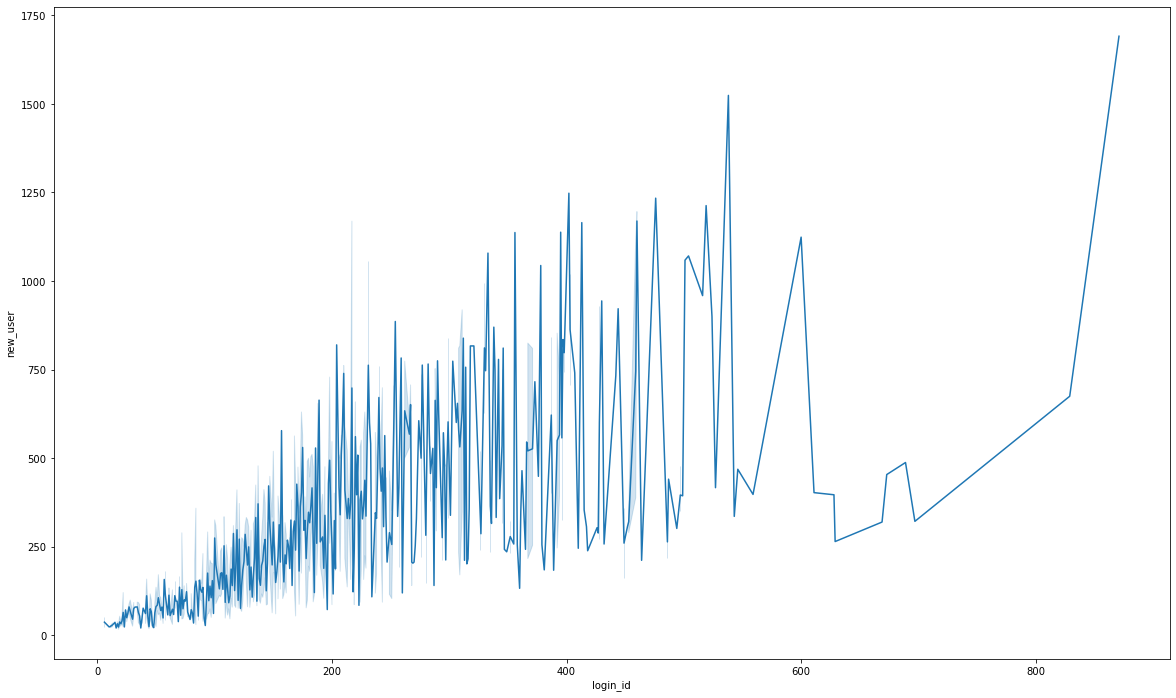

In [16]:
## import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,12))
sns.lineplot(train["login_id"], train["new_user"])

# 데이터 분할

In [17]:
train["active_people"] = active_people[:808]
test["active_people"] = active_people[808:]

train['count_sub'] = count_sub[40:-31]
test['count_sub'] = count_sub[-31:]

#각각의 페이지마다 점수를 떨어뜨리는 columns을 drop
train2 = train.drop(["user","session","new_user","page_view"],1)
train_page = train2.drop(["active_people", "count_sub"],1)
test_page = test.drop(["active_people", "count_sub"],1)
train_user = train2
test_user = test
train_session = train2.drop(["prize"],1)
test_session = test.drop(["prize"],1)
train_new_user = train2.drop(["prize"],1)
test_new_user = test.drop(["prize"],1)

display(train2, test)

,login_id,user_id,prize,vacation,count_comp,week,year,month,week_day,quarter,active_people,count_sub
DateTime,,,,,,,,,,,,
2018-09-23,35.0,32.0,350.0,0,1,38,2018,9,6,3,1.0,30
2018-09-24,30.0,29.0,350.0,0,1,39,2018,9,0,3,2.0,35
2018-09-25,18.0,18.0,350.0,0,1,39,2018,9,1,3,3.0,28
2018-09-26,48.0,45.0,350.0,0,1,39,2018,9,2,3,3.0,47
2018-09-27,31.0,30.0,350.0,0,1,39,2018,9,3,3,3.0,41
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-04,276.0,275.0,2500.0,0,7,49,2020,12,4,4,7116.0,352
2020-12-05,143.0,143.0,2500.0,0,6,49,2020,12,5,4,7121.0,197
2020-12-06,169.0,168.0,2500.0,0,6,49,2020,12,6,4,7125.0,192


,login_id,user_id,prize,vacation,count_comp,week,year,month,week_day,quarter,active_people,count_sub
DateTime,,,,,,,,,,,,
2020-12-09,493,491,2500.0,0,6,50,2020,12,2,4,7154.0,217
2020-12-10,350,344,2500.0,0,5,50,2020,12,3,4,7170.0,190
2020-12-11,256,254,2500.0,0,5,50,2020,12,4,4,7181.0,213
2020-12-12,183,177,2500.0,0,5,50,2020,12,5,4,7185.0,232
2020-12-13,153,153,2500.0,0,5,50,2020,12,6,4,7190.0,187
2020-12-14,307,304,2500.0,0,5,51,2020,12,0,4,7198.0,250
2020-12-15,338,333,2500.0,0,6,51,2020,12,1,4,7211.0,259
2020-12-16,304,300,2500.0,0,6,51,2020,12,2,4,7220.0,193
2020-12-17,307,306,2500.0,0,6,51,2020,12,3,4,7232.0,213


# 모델

<Figure size 1440x864 with 0 Axes>

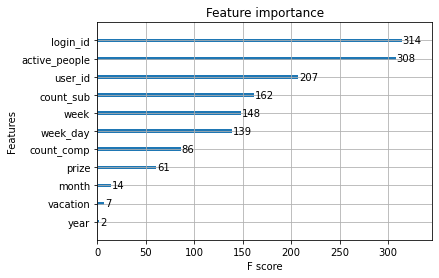

<Figure size 1440x864 with 0 Axes>

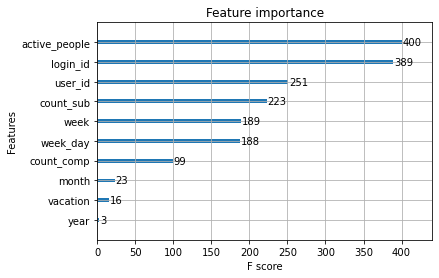

<Figure size 1440x864 with 0 Axes>

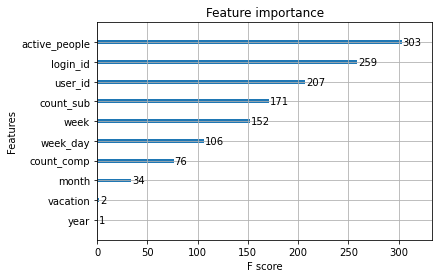

<Figure size 1440x864 with 0 Axes>

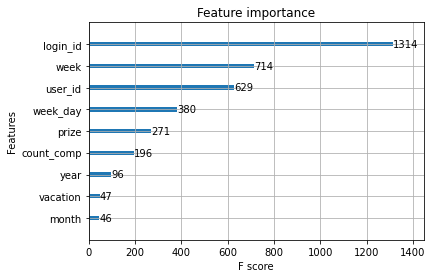

In [18]:
from sklearn.linear_model import Ridge,Lasso
from xgboost import XGBRegressor, plot_importance

#xgboost와 ridge를 각각 정답 컬럼에 맞게 앙상블
#ridge를 추가해서 트리구조로 학습하기 쉽지 않은 부분을 보완
result_list = pd.DataFrame(index = pd.date_range("2020-12-09", periods = 31, freq = 'd'))
for i,j in zip(["user", "session", "new_user", "page_view"], ["사용자", "세션", "신규방문자", "페이지뷰"]):
    if (i == "user"):
        xg = XGBRegressor(n_estimators=60, learning_rate=0.1, max_depth=5)
        xg.fit(train_user, train[i])
        result_list[j] = xg.predict(test_user) * 0.8
        train_user = train_user.drop(["vacation"],1)
        test_user = test_user.drop(["vacation"],1)
        ridge = Ridge(alpha=40)
        ridge.fit(train_user, train[i])
        result_list[j] += ridge.predict(test_user) * 0.2
    elif (i == "session"):
        xg = XGBRegressor(n_estimators=80, learning_rate=0.1, max_depth=5)
        xg.fit(train_session, train[i])
        result_list[j] = xg.predict(test_session) * 0.8
        train_session = train_session.drop(["vacation"],1)
        test_session = test_session.drop(["vacation"],1)
        ridge = Ridge(alpha=40)
        ridge.fit(train_session, train[i])
        result_list[j] += ridge.predict(test_session) * 0.2
    elif (i == "new_user"):
        xg = XGBRegressor(n_estimators=60, learning_rate=0.1, max_depth=5)
        xg.fit(train_new_user, train[i])
        result_list[j] = xg.predict(test_new_user) * 0.4
        train_new_user = train_new_user.drop(["vacation"],1)
        test_new_user = test_new_user.drop(["vacation"],1)
        ridge = Ridge(alpha=40)
        ridge.fit(train_new_user, train[i])
        result_list[j] += ridge.predict(test_new_user) * 0.6
    elif (i == "page_view"):
        xg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
        xg.fit(train_page, train[i])
        result_list[j] = xg.predict(test_page) * 0.7
        train_page = train_page.drop(["month", "quarter","vacation"],1)
        test_page = test_page.drop(["month", "quarter","vacation"],1)
        ridge = Ridge(alpha=40)
        ridge.fit(train_page,train[i])
        result_list[j] += ridge.predict(test_page) * 0.3
    plt.figure(figsize=(20,12))
    plot_importance(xg)


# 평가

In [19]:
from sklearn.model_selection import cross_val_score

#cross_val_score통해서 점수 계산
xg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
for i in ["user", "session", "new_user", "page_view"]:
    if ((i == "page_view")):
        print(i,cross_val_score(xg, train_page, train[i], cv=5, scoring=my_scorer).mean() / train[i].mean())
    elif ((i == "user")):
        print(i,cross_val_score(xg, train_user, train[i], cv=5, scoring=my_scorer).mean() / train[i].mean())
    elif ((i == "session")):
        print(i,cross_val_score(xg, train_session, train[i], cv=5, scoring=my_scorer).mean() / train[i].mean())
    elif ((i == "new_user")):
        print(i,cross_val_score(xg, train_new_user, train[i], cv=5, scoring=my_scorer).mean() / train[i].mean())

ridge = Ridge(alpha=40)
for i in ["user", "session", "new_user", "page_view"]:
    if ((i == "page_view")):
        print(i,cross_val_score(ridge, train_page, train[i], cv=5, scoring=my_scorer).mean() / train[i].mean())
    elif ((i == "user")):
        print(i,cross_val_score(ridge, train_user, train[i], cv=5, scoring=my_scorer).mean() / train[i].mean())
    elif ((i == "session")):
        print(i,cross_val_score(ridge, train_session, train[i], cv=5, scoring=my_scorer).mean() / train[i].mean())
    elif ((i == "new_user")):
        print(i,cross_val_score(ridge, train_new_user, train[i], cv=5, scoring=my_scorer).mean() / train[i].mean())


user 0.28928746592407795
session 0.30221093851653735
new_user 0.4869901347408206
page_view 0.3620714835861391
user 0.30759040854343117
session 0.31089335953311853
new_user 0.4799281189952821
page_view 0.9921251595933067


# 제출

In [20]:
result_list.index = range(0,31)

train_final.index = pd.to_datetime(train_final["DateTime"])
train_final = train_final.drop(['DateTime'],1)
train_final = train_final.resample('D').sum()

#2차 공개에서 주어진 값과 예측한 값을 이어붙이기
result1 = train_final[["사용자", "세션", "신규방문자", "페이지뷰"]][-30:]
result1.index = range(0,30)
result1.columns = ["사용자", "세션", "신규방문자", "페이지뷰"]
result1 = pd.concat([result1,result_list])
result1.index = range(0,61)
result1

sub = pd.read_csv("/kaggle/input/2020daconcupsecondversion/open_data (1)/submission.csv", encoding='cp949')
sub = sub.drop(["사용자", "세션", "신규방문자", "페이지뷰"], 1)

sub = pd.merge(sub, result1, left_index=True, right_index=True, how="outer")
sub = sub.fillna(0)

display(sub, result_list)

sub.to_csv("dacon_cup.csv", index=0, encoding='cp949')

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,4364.000000,4340.000000,1143.000000,95408.000000
1,2020-11-10,4370.000000,4256.000000,1137.000000,99623.000000
2,2020-11-11,4492.000000,4449.000000,1071.000000,114438.000000
3,2020-11-12,3998.000000,3899.000000,796.000000,94730.000000
4,2020-11-13,4130.000000,3967.000000,835.000000,101484.000000
5,2020-11-14,2690.000000,2620.000000,509.000000,61926.000000
6,2020-11-15,2717.000000,2643.000000,478.000000,71357.000000
7,2020-11-16,5200.000000,5079.000000,1124.000000,142311.000000
8,2020-11-17,3948.000000,3892.000000,944.000000,107879.000000
9,2020-11-18,3538.000000,3415.000000,839.000000,79713.000000


,사용자,세션,신규방문자,페이지뷰
0,3762.784051,3735.035532,995.038619,99077.310081
1,3159.483764,3209.215611,834.751561,79611.439874
2,2724.620117,2752.096208,731.282853,64947.533533
3,2295.558685,2278.831261,564.382484,53481.954373
4,2126.567582,2026.385576,534.059049,49997.197552
5,3060.144067,3056.743365,817.483852,72132.472783
6,3268.558301,3259.346176,849.065111,82128.858707
7,3044.236586,3007.238149,811.477846,73923.102360
8,3050.360778,3020.948602,806.257956,74035.184980
9,3724.159848,3702.758602,949.109686,95420.674211


In [21]:
sub

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,4364.000000,4340.000000,1143.000000,95408.000000
1,2020-11-10,4370.000000,4256.000000,1137.000000,99623.000000
2,2020-11-11,4492.000000,4449.000000,1071.000000,114438.000000
3,2020-11-12,3998.000000,3899.000000,796.000000,94730.000000
4,2020-11-13,4130.000000,3967.000000,835.000000,101484.000000
5,2020-11-14,2690.000000,2620.000000,509.000000,61926.000000
6,2020-11-15,2717.000000,2643.000000,478.000000,71357.000000
7,2020-11-16,5200.000000,5079.000000,1124.000000,142311.000000
8,2020-11-17,3948.000000,3892.000000,944.000000,107879.000000
9,2020-11-18,3538.000000,3415.000000,839.000000,79713.000000
